## Model - ResBlock_CBAM YOLOv8 (attention)
## type - All In One 
## Dataset - VisDrone 
## Test - Extended

# 1. Install Dependencies

In [1]:
# !git clone https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8.git
!git clone https://github.com/mohitsharma-iitj/SEblock_yolov8.git

Cloning into 'SEblock_yolov8'...
remote: Enumerating objects: 192, done.
remote: Counting objects: 100% (192/192), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 192 (delta 29), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (192/192), 3.00 MiB | 14.28 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
%cd SEblock_yolov8

/kaggle/working/SEblock_yolov8


In [3]:
%pip install -r requirements.txt

  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.8/530.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00
  C

# 2. Dataset Preparation (Annotation)

as the format of annotation is as - object-class,x_center,y_center,width,height (all normalized as this is input format for YOLO5 prediction)

igiven annotation (in pixel) - bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

os.makedirs('/kaggle/working/yolo_dataset/images', exist_ok=True)
os.makedirs('/kaggle/working/yolo_dataset/labels', exist_ok=True)

In [5]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.width, img.height


# Function to convert annotations
def convert_to_yolo_format(filename, annotations, img_width, img_height,output_annotations_path):
    with open(os.path.join(output_annotations_path, filename), 'w') as out_file:
        for annotation in annotations:
            if len(annotation) != 8:
                print(f"Error parsing annotation in {filename}: {annotation}")
                continue
            x_min, y_min, width, height, score, class_id, truncation, occlusion = map(float, annotation)
            if(class_id==0):
                continue
            # Convert to YOLO format
            center_x = x_min + (width / 2.0)
            center_y = y_min + (height / 2.0)
            center_x /= img_width
            center_y /= img_height
            width /= img_width
            height /= img_height
            class_id = class_id -1
            out_file.write(f"{int(class_id)} {center_x} {center_y} {width} {height}\n")

In [6]:
def create_dataset(annotations_path,images_path,xx):
    output_dataset_path = '/kaggle/working/yolo_dataset'
    lab_ = 'labels/'+ xx
    img_ = 'images/'+ xx
    output_annotations_path = os.path.join(output_dataset_path, lab_)
    output_images_path = os.path.join(output_dataset_path, img_)


    os.makedirs(output_annotations_path, exist_ok=True)
    os.makedirs(output_images_path, exist_ok=True)

    # Process all annotation files
    for annotation_file in os.listdir(annotations_path):
        image_file = annotation_file.replace('.txt', '.jpg')
        image_path = os.path.join(images_path, image_file)

        if not os.path.exists(image_path):
            continue

        img_width, img_height = get_image_dimensions(image_path)

        with open(os.path.join(annotations_path, annotation_file), 'r') as file:
            lines = file.readlines()
            annotations = [line.strip().split(',') for line in lines]
            convert_to_yolo_format(annotation_file, annotations, img_width, img_height,output_annotations_path)

            # Copy the image to the new dataset location
            output_image_path = os.path.join(output_images_path, image_file)
            if not os.path.exists(output_image_path):
                Image.open(image_path).save(output_image_path)

## From VisDrone Dataset

For train (from visdrone )

In [7]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-train/VisDrone2019-DET-train/images'

create_dataset(annotations_path,images_path,'train')

Error parsing annotation in 9999974_00000_d_0000053.txt: ['440', '541', '271', '152', '1', '6', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['436', '772', '134', '72', '1', '5', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['601', '713', '60', '39', '1', '10', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['486', '706', '102', '59', '1', '8', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['397', '978', '167', '90', '1', '4', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['718', '1063', '23', '14', '1', '1', '1', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['696', '13', '21', '33', '1', '3', '0', '0', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['1124', '73', '98', '62', '1', '5', '0', '1', '']
Error parsing annotation in 9999974_00000_d_0000053.txt: ['1089', '35', '84', '46', '1', '7', '0', '1', '']
Error parsing annotati

For val (from visdrone )

In [8]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-val/VisDrone2019-DET-val/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-val/VisDrone2019-DET-val/images'

create_dataset(annotations_path,images_path,'val')

For test dataset (from visDrone)

In [9]:
# Paths to the dataset
annotations_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/annotations'
images_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images'

create_dataset(annotations_path,images_path,'test_vis')

## From Expanded Dataset

For test dataset (from extended)

In [10]:
# Paths to the dataset
annotations_path = '/kaggle/input/extended-dataset/Expanded_dataset/annotations'
images_path = '/kaggle/input/extended-dataset/Expanded_dataset/images'

create_dataset(annotations_path,images_path,'test_ext')

# 3. Create function for configuration, train, test

for yaml (file structure configuration)

In [11]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/val
test: /kaggle/working/yolo_dataset/images/test_vis

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""
# test: /kaggle/working/yolo_dataset/test_ext/images

with open('/kaggle/working/yolo_dataset/traintest_vis.yaml', 'w') as file:
    file.write(data_config)
    
    
traintest_vis_yaml = '/kaggle/working/yolo_dataset/traintest_vis.yaml'

In [12]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test_ext

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/test_ext.yaml', 'w') as file:
    file.write(data_config)
    
test_ext_yaml = '/kaggle/working/yolo_dataset/test_ext.yaml'

paths

In [13]:
path_best_pt = "/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt"
path_last_pt = "/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt"

helper for train, test

In [14]:
def train_on_visdrone(model,epoch_):
    !export WANDB_MODE=disabled
    wandb.init(mode="disabled")
    # Load a model
    model = YOLO(path_last_pt)  # load a partially trained model (checkpoint of last trained)

    # Train the model  #  X(from model,previous) + Y (=epoch_) = given segment epoch
    results = model.train(data=traintest_vis_yaml, epochs=epoch_, imgsz=640, batch=8)
    
    
def test_on_visdrone(model):  # on same dataset
    # coming  after training, uses last model
    model = YOLO(path_best_pt)
    test_results = model.val(data=traintest_vis_yaml, split='test')


def test_on_extended(model):  # on diff dataset
    model = YOLO(path_best_pt)  # load best model

    # Evaluate the model on the new dataset
    test_results = model.val(data=test_ext_yaml, split='val')
    


# Training Yolov8s

In [15]:
import wandb
from ultralytics import YOLO


# epoch = 10

for this, helper cant be use, as pretrained model weights are used

In [16]:
!export WANDB_MODE=disabled
wandb.init(mode="disabled")



model_yaml = '/kaggle/working/SEblock_yolov8/ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml'

# Load a YOLOv8 model (pretrained + attention head)
model = YOLO(model_yaml).load('/kaggle/working/SEblock_yolov8/yolov8n.pt') # load thode weights which layer exit, except attention , load weight of other layers

# Train the model
results = model.train(data=traintest_vis_yaml, epochs=10, imgsz=640, batch=8)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295

In [17]:
# !gdown https://github.com/RuiyangJu/Fracture_Detection_Improved_YOLOv8/releases/download/YOLOv8_ResCBAM/YOLOv8_ResCBAM.pt

#   !python start_train.py --model ./ultralytics/cfg/models/v8/yolov8_ResBlock_CBAM.yaml --data_dir ./GRAZPEDWRI-DX/data/meta.yaml

test on visdrone  epoch=10

In [18]:
test_on_visdrone(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:01<00:00, 1040.92it/s]
val: New cache created: /kaggle/working/yolo_dataset/labels/test_vis.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:00<00:00,  1.67it/s]
                   all       1610      75367      0.332      0.199      0.161     0.0828
            pedestrian       1610      21006      0.245      0.165      0.141     0.0506
                people       1610

#### Test on extended  epoch=10 

In [19]:
test_on_extended(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:01<00:00, 997.68it/s] 
val: New cache created: /kaggle/working/yolo_dataset/labels/test_ext.cache
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:32<00:00,  2.52it/s]
                   all       1301      46645      0.349      0.137      0.104     0.0497
            pedestrian       1301      13460      0.276      0.047     0.0505     0.0209
                people       1301  

# Epoch=25

In [20]:
train_on_visdrone(model,15)  # 10 + 15 


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.49 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=15, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [21]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:46<00:00,  1.06s/it]
                   all       1610      75367      0.289      0.232      0.203      0.109
            pedestrian       1610      21006      0.326      0.199      0.177     0.0656
                people       1610       6376      0.333     0.0681     0.0764     0.0232
               bicycle 

#### Test on extended  epoch=25 

In [22]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:57<00:00,  1.41it/s]
                   all       1301      46645      0.293      0.154      0.125     0.0632
            pedestrian       1301      13460      0.315     0.0578     0.0598     0.0251
                people       1301       4438      0.102    0.00203    0.00965    0.00308
               bicycle   

# Epoch = 50

In [23]:
train_on_visdrone(model,25)  # 25 + 25 


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=25, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [24]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:48<00:00,  1.07s/it]
                   all       1610      75367      0.365      0.248       0.22      0.118
            pedestrian       1610      21006      0.424      0.192      0.197     0.0749
                people       1610       6376      0.395     0.0593      0.087     0.0277
               bicycle 

#### Test on extended  epoch=50 

In [25]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:55<00:00,  1.48it/s]
                   all       1301      46645      0.195      0.159      0.126     0.0652
            pedestrian       1301      13460      0.362     0.0463     0.0555     0.0247
                people       1301       4438      0.131    0.00248     0.0109    0.00334
               bicycle   

# Epoch = 100

In [26]:
train_on_visdrone(model,50)  # 25 + 25 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt, data=/kaggle/working/yolo_dataset/traintest_vis.yaml, epochs=50, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=True, save

In [27]:
test_on_visdrone(model)


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:49<00:00,  1.08s/it]
                   all       1610      75367      0.357      0.258      0.237       0.13
            pedestrian       1610      21006      0.443      0.203      0.211     0.0801
                people       1610       6376      0.429     0.0736     0.0999      0.033
               bicycle 

#### Test on extended  epoch=100

In [28]:
test_on_extended(model)

Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_ext.cache... 1301 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1301/1301 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:57<00:00,  1.42it/s]
                   all       1301      46645      0.219      0.164      0.131     0.0689
            pedestrian       1301      13460      0.353     0.0386      0.047     0.0206
                people       1301       4438      0.115    0.00248     0.0107    0.00343
               bicycle   

# 6.a. Make Predictions on Extended from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1.jpg: 448x640 10 cars, 1 van, 1 truck, 93.1ms
Speed: 5.5ms preprocess, 93.1ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8089504241943359, BBox: (660, 590, 768, 682)
Class: 3, Confidence: 0.8083047866821289, BBox: (591, 620, 679, 702)
Class: 3, Confidence: 0.7694531083106995, BBox: (410, 431, 488, 512)
Class: 3, Confidence: 0.6793559193611145, BBox: (572, 3, 601, 36)
Class: 3, Confidence: 0.5271002054214478, BBox: (498, 8, 524, 33)
Class: 3, Confidence: 0.44839322566986084, BBox: (345, 280, 393, 344)
Class: 3, Confidence: 0.4439474046230316, BBox: (404, 76, 441, 112)
Class: 3, Confidence: 0.40447643399238586, BBox: (466, 5, 498, 37)
Class: 4, Confidence: 0.39470207691192627, BBox: (403, 76, 441, 112)
Class: 3, Confidence: 0.37994620203971863, BBox: (948, 229, 977, 259)
Class: 3, Confidence: 0.33631646633148193, BBox: (933, 257, 963, 293)
Class: 5, Confidence: 0.25852665305137634, BBox: (0, 333, 81, 378)


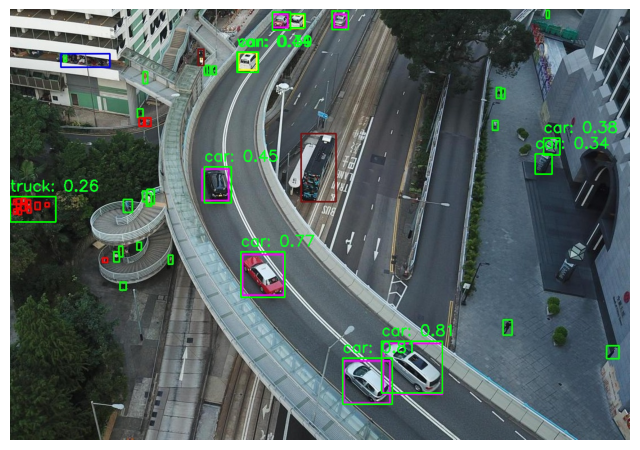


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/1011.jpg: 352x640 2 pedestrians, 1 car, 1 van, 1 truck, 1 bus, 106.1ms
Speed: 4.9ms preprocess, 106.1ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.5726165771484375, BBox: (138, 410, 211, 526)
Class: 4, Confidence: 0.5329079627990723, BBox: (214, 77, 274, 181)
Class: 8, Confidence: 0.47866493463516235, BBox: (0, 514, 91, 691)
Class: 5, Confidence: 0.3312496542930603, BBox: (658, 325, 711, 444)
Class: 0, Confidence: 0.28890007734298706, BBox: (1187, 162, 1198, 181)
Class: 0, Confidence: 0.26202741265296936, BBox: (1171, 163, 1183, 185)


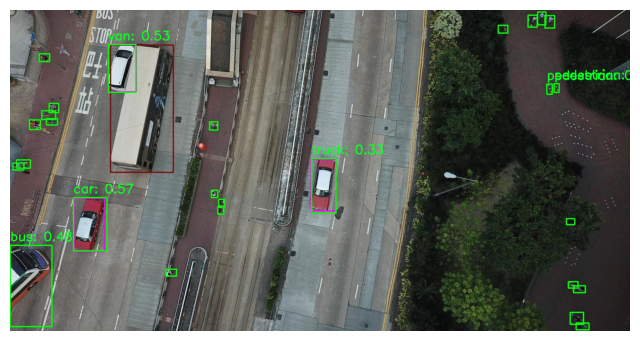


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/932.jpg: 352x640 2 cars, 1 van, 2 buss, 11.3ms
Speed: 2.3ms preprocess, 11.3ms inference, 2.8ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.488471657037735, BBox: (597, 56, 621, 104)
Class: 3, Confidence: 0.4472091495990753, BBox: (555, 129, 584, 177)
Class: 8, Confidence: 0.36522889137268066, BBox: (262, 124, 321, 165)
Class: 8, Confidence: 0.301449179649353, BBox: (494, 514, 530, 595)
Class: 4, Confidence: 0.2861945629119873, BBox: (263, 125, 321, 165)


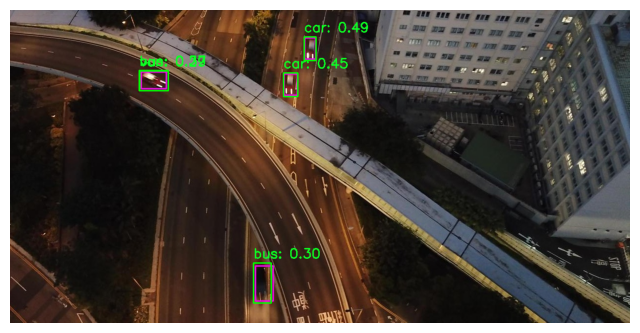


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/846.jpg: 352x640 11 cars, 1 van, 3 trucks, 1 awning-tricycle, 2 buss, 11.9ms
Speed: 2.9ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 352, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8203218579292297, BBox: (616, 510, 798, 655)
Class: 3, Confidence: 0.804006040096283, BBox: (641, 319, 696, 375)
Class: 3, Confidence: 0.8017163872718811, BBox: (560, 415, 689, 507)
Class: 3, Confidence: 0.668829619884491, BBox: (618, 254, 652, 285)
Class: 5, Confidence: 0.6332640647888184, BBox: (496, 231, 539, 274)
Class: 5, Confidence: 0.6298753619194031, BBox: (512, 304, 577, 375)
Class: 3, Confidence: 0.6131446957588196, BBox: (619, 228, 648, 257)
Class: 3, Confidence: 0.5358645915985107, BBox: (561, 227, 590, 256)
Class: 4, Confidence: 0.4946739077568054, BBox: (841, 259, 900, 303)
Class: 5, Confidence: 0.3730279803276062, BBox: (685, 261, 738, 307)
Class: 8, Confidence: 0.33238551020622253, BBox: (685, 260, 738, 307)
Class: 8, Confidence: 0.3065893054008484, BBox: (118, 276, 246, 330)
Class: 3, Confidence: 0.29393303394317627, BBox: (577, 186, 596, 204)
Class: 3, Confidence: 0.28452280163764954, BBox: (880, 285, 940, 323)
Class: 3, 

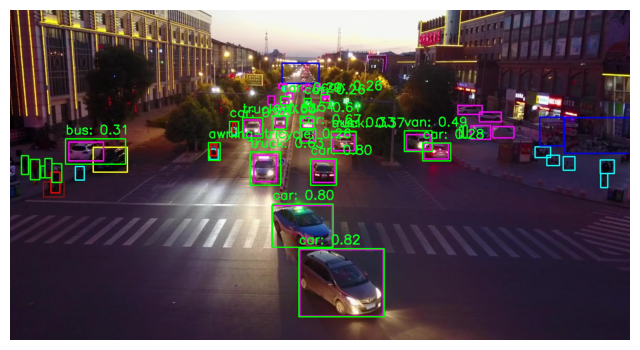


image 1/1 /kaggle/input/extended-dataset/Expanded_dataset/images/493.jpg: 320x640 4 cars, 1 van, 1 bus, 79.1ms
Speed: 3.2ms preprocess, 79.1ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


Predicted Annotations:
Class: 3, Confidence: 0.6829416155815125, BBox: (471, 359, 500, 410)
Class: 3, Confidence: 0.38175198435783386, BBox: (372, 213, 397, 261)
Class: 3, Confidence: 0.3457331657409668, BBox: (620, 264, 652, 311)
Class: 3, Confidence: 0.3369535803794861, BBox: (436, 123, 460, 179)
Class: 8, Confidence: 0.2868593633174896, BBox: (987, 521, 1109, 571)
Class: 4, Confidence: 0.25739067792892456, BBox: (808, 514, 861, 539)


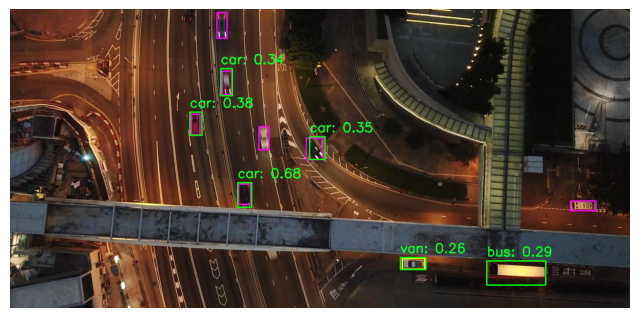

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO


# Load the trained YOLOv8 model
model = YOLO(path_best_pt)  # load a partially trained model
# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = [1,1011,932,846,493]
for img_locat in listimg:
    # Define the test image path
    test_image_path = '/kaggle/input/extended-dataset/Expanded_dataset/images/'+ str(img_locat) + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 6.b. Make Predictions on visdrone from best model
Use the trained model to make predictions on new images:


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000006_00159_d_0000001.jpg: 384x640 30 cars, 2 vans, 10 trucks, 80.6ms
Speed: 5.8ms preprocess, 80.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:
Class: 3, Confidence: 0.8622250556945801, BBox: (685, 468, 794, 525)
Class: 3, Confidence: 0.8400970101356506, BBox: (660, 352, 751, 389)
Class: 3, Confidence: 0.8094539642333984, BBox: (433, 544, 568, 597)
Class: 3, Confidence: 0.7974527478218079, BBox: (849, 345, 894, 391)
Class: 3, Confidence: 0.7958349585533142, BBox: (808, 310, 876, 344)
Class: 3, Confidence: 0.7874467968940735, BBox: (483, 507, 606, 560)
Class: 3, Confidence: 0.7753840088844299, BBox: (475, 420, 577, 467)
Class: 3, Confidence: 0.7489891648292542, BBox: (898, 345, 939, 390)
Class: 3, Confidence: 0.7451431155204773, BBox: (757, 346, 800, 389)
Class: 3, Confidence: 0.7442052364349365, BBox: (502, 448, 611, 492)
Class: 3, Confidence: 0.734741747379303, BBox: (997, 129, 1029, 147)
Class: 5, Confidence: 0.7115921974182129, BBox: (15, 251, 87, 314)
Class: 3, Confidence: 0.6885806918144226, BBox: (0, 385, 59, 454)
Class: 3, Confidence: 0.6879664659500122, BBox: (804, 349, 844, 389)
Class: 3, Confid

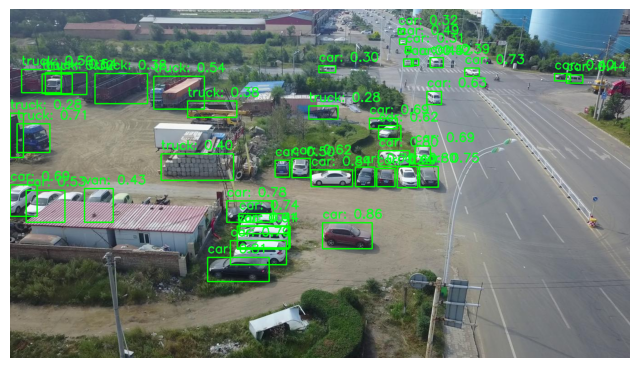


image 1/1 /kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/0000054_00786_d_0000001.jpg: 384x640 71 pedestrians, 1 car, 12.7ms
Speed: 3.4ms preprocess, 12.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)


Predicted Annotations:
Class: 0, Confidence: 0.8620803952217102, BBox: (303, 301, 337, 369)
Class: 0, Confidence: 0.8418128490447998, BBox: (664, 322, 709, 388)
Class: 0, Confidence: 0.8305581212043762, BBox: (267, 268, 297, 333)
Class: 0, Confidence: 0.817742109298706, BBox: (193, 297, 226, 362)
Class: 0, Confidence: 0.8070218563079834, BBox: (843, 230, 879, 282)
Class: 0, Confidence: 0.7909000515937805, BBox: (522, 162, 542, 213)
Class: 0, Confidence: 0.7905113697052002, BBox: (251, 423, 290, 512)
Class: 3, Confidence: 0.7856395840644836, BBox: (0, 71, 85, 125)
Class: 0, Confidence: 0.7762303948402405, BBox: (730, 340, 768, 395)
Class: 0, Confidence: 0.762246310710907, BBox: (378, 184, 400, 236)
Class: 0, Confidence: 0.7601152658462524, BBox: (405, 334, 433, 402)
Class: 0, Confidence: 0.7592568397521973, BBox: (780, 219, 813, 283)
Class: 0, Confidence: 0.7467433214187622, BBox: (387, 144, 410, 196)
Class: 0, Confidence: 0.7432315349578857, BBox: (261, 344, 296, 411)
Class: 0, Confide

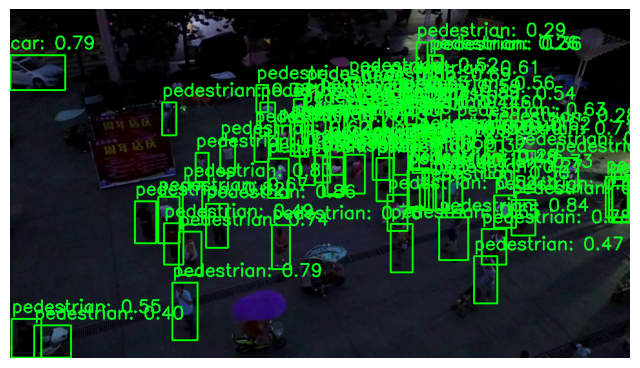

In [30]:
import os
import cv2
import matplotlib.pyplot as plt
# from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model

# model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

listimg = ['0000006_00159_d_0000001','0000054_00786_d_0000001']
for img_locat in listimg:
    # Define the test image path
    # test_image_path = '/kaggle/input/custom-dataset/images/1001.jpg'
    test_image_path = '/kaggle/input/visdrone-dataset/VisDrone2019-DET-test-dev/VisDrone2019-DET-test-dev/images/'+ img_locat + '.jpg'

    # Load the test image
    img = cv2.imread(test_image_path)

    # Predict the bounding boxes
    results = model(test_image_path)

    # Print the predicted annotations
    print("Predicted Annotations:")
    for result in results:
        for bbox in result.boxes:
            bbox_array = bbox.xyxy[0].cpu().numpy()  # Convert to numpy array
            x1, y1, x2, y2 = map(int, bbox_array)  # Convert to integers
            class_id = int(bbox.cls)
            confidence = float(bbox.conf)
            print(f"Class: {class_id}, Confidence: {confidence}, BBox: {x1, y1, x2, y2}")
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f'{model.names[class_id]}: {confidence:.2f}', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

    # Display the images
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Extra

In [31]:
data_config = """
train: /kaggle/working/yolo_dataset/images/train
val: /kaggle/working/yolo_dataset/images/test_vis

nc: 11  # number of classes (modify according to your dataset)
names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
"""

with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
    file.write(data_config)

In [32]:
# Load the best model
model = YOLO(path_best_pt)  # load a partially trained model

test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')


Ultralytics YOLOv8.0.147 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8_ResBlock_CBAM summary: 244 layers, 4241017 parameters, 0 gradients, 10.5 GFLOPs
val: Scanning /kaggle/working/yolo_dataset/labels/test_vis.cache... 1610 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1610/1610 [00:00<?, ?it/s]
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 101/101 [01:06<00:00,  1.53it/s]
                   all       1610      75367      0.357      0.258      0.237       0.13
            pedestrian       1610      21006      0.443      0.203      0.211     0.0801
                people       1610       6376      0.429     0.0736     0.0999      0.033
               bicycle 

# END 

saved code if error occur

In [33]:
# data_config = """
# train: /kaggle/working/yolo_dataset/images/train
# val: /kaggle/working/yolo_dataset/images/val
# test: /kaggle/working/yolo_dataset/images/test

# nc: 11  # number of classes (modify according to your dataset)
# names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
# """

# with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
#     file.write(data_config)

# # test: /kaggle/working/yolo_dataset/test_ext/images

# import wandb
# !export WANDB_MODE=disabled
# wandb.init(mode="disabled")


# from ultralytics import YOLO

# # Load a YOLOv8 model
# model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/last.pt")  # load a partially trained model

# # Train the model
# results = model.train(data='/kaggle/working/yolo_dataset/data.yaml', epochs=1, imgsz=640, batch=16)

# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='test')

# data_config = """
# train: /kaggle/working/yolo_dataset/train/images
# val: /kaggle/working/yolo_dataset/test_ext/images

# nc: 11  # number of classes (modify according to your dataset)
# names: ['pedestrian', 'people', 'bicycle', 'car', 'van', 'truck', 'tricycle', 'awning-tricycle', 'bus', 'motor', 'others']  # class names (modify according to your dataset)
# """

# with open('/kaggle/working/yolo_dataset/data.yaml', 'w') as file:
#     file.write(data_config)
    
    
# # Load the best model
# model = YOLO("/kaggle/working/SEblock_yolov8/runs/detect/train/weights/best.pt")  # load a partially trained model


# # Evaluate the model on the new dataset
# test_results = model.val(data='/kaggle/working/yolo_dataset/data.yaml', split='val')
